[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drdave-teaching/OPIM5509Files/blob/main/OPIM5509_Module4_Files/Univariate_Temperature_RNN_Advanced.ipynb)

# Univariate Temperature Example (Advanced)
**Dr. Dave Wanik - University of Connecticut**

Let's see if we can predict the temperature as a function of N previous days - building on our previous script, and adding some 1D convolutions, 1D maxpooling, and dropout. Just make sure your sequences are long enough to do meaningful convolutions!

In [ ]:
# standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RNN-specific modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

## Read in data
Check for missing values, make some plots.

In [ ]:
# read the data
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
df = pd.read_csv(url)
print(df.info())
df.head(n=15) # nice complete data! this will allow us to check our work later

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB
None


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
5,1981-01-06,15.8
6,1981-01-07,15.8
7,1981-01-08,17.4
8,1981-01-09,21.8
9,1981-01-10,20.0


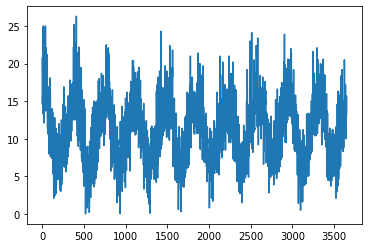

In [ ]:
# visualize the data
df['Temp'].plot()
plt.show()

In [ ]:
# prep data for modeling (univariate)
# link: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
# here's an example of how this script works
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[10 20 30] 40
[20 30 40] 50
[30 40 50] 60
[40 50 60] 70
[50 60 70] 80
[60 70 80] 90


In [ ]:
# all we need to do is decide on is n_steps (what our lookback period is)
# since we have a bunch of data, why not n_steps=10? then try 30 later on.
n_steps = 30 # long enough to do convolutions!
raw_seq = df['Temp'] # the second column, where the data is. UPDATE THIS ON YOUR DATA!
# let's ignore the date column and just use the temperature data
X, y = split_sequence(raw_seq, n_steps)

In [ ]:
# take a peak at what it did
print(X[0])
print(y[0])

# scroll up and make sure you understand this!
# y is a function of X (the previous n_steps observations!)

[20.7 17.9 18.8 14.6 15.8 15.8 15.8 17.4 21.8 20.  16.2 13.3 16.7 21.5
 25.  20.7 20.6 24.8 17.7 15.5 18.2 12.1 14.4 16.  16.5 18.7 19.4 17.2
 15.5 15.1]
15.4


In [ ]:
# now we reshape the data into a 3D array
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1 # this is 1 because it is univariate data
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
# split the data into train and test partitions
# we will use 90% of the data for train, and 10% for validation
train_pct_index = int(0.9 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

# pretty slick way of splitting your data using slicing!
# notice how we didn't do any shuffling (we don't want temporal leakage! keeps time series intact)

In [ ]:
# check the shape to be sure
print(X.shape, X_train.shape, X_test.shape)

# verify that this all adds up!
# samples, length, variables

(3620, 30, 1) (3258, 30, 1) (362, 30, 1)


In [ ]:
# peak at it!
X_train[0]

array([[20.7],
       [17.9],
       [18.8],
       [14.6],
       [15.8],
       [15.8],
       [15.8],
       [17.4],
       [21.8],
       [20. ],
       [16.2],
       [13.3],
       [16.7],
       [21.5],
       [25. ],
       [20.7],
       [20.6],
       [24.8],
       [17.7],
       [15.5],
       [18.2],
       [12.1],
       [14.4],
       [16. ],
       [16.5],
       [18.7],
       [19.4],
       [17.2],
       [15.5],
       [15.1]])

In [ ]:
# if we wanted to, we could do some scaling/normalization here, would not hurt!

# RNN one layer model (with Conv and Pooling)

In [ ]:
# now let's build a model

# since this is a univariate problem, n_features will be 1 (we also defined this before)
n_steps = 30
n_features = 1

# for Conv1D, you can play with the filters and kernel size

# define model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, input_shape=(n_steps,n_features))) # notice how input shape goes in first layer
model.add(MaxPooling1D(2))
model.add(SimpleRNN(30, activation='relu'))
model.add(Dropout(0.1)) # pick a number between 0.1 and 0.3
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model.fit(X_train, y_train,
          epochs=500,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 32)           0         
 )                                                               
                                                                 
 simple_rnn (SimpleRNN)      (None, 30)                1890      
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
______________________________________________________

12/12 [==============================] - 0s 3ms/step
MAE:  1.7638263186038532


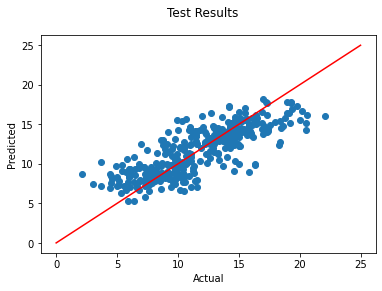

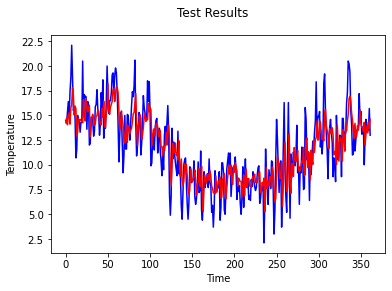

In [ ]:
# show scatterplots of actual vs. predicted for train and test
# make a prediction
pred = model.predict(X_test)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, pred))

actual = y_test # the actual
plt.scatter(x=actual, y=pred)
x = np.linspace(0,25) # 45 degree line from 0 to 25 (axes are the same)
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

# RNN two layer model
Don't forget to set return_sequences=True!

In [ ]:
# now let's build a model
from keras.layers import Bidirectional

# since this is a univariate problem, n_features will be 1 (we also defined this before)
n_features = 1

# define model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, input_shape=(n_steps,n_features))) # notice how input shape goes in first layer
model.add(MaxPooling1D())
model.add(Bidirectional(SimpleRNN(30, return_sequences=True, activation='relu')))
model.add(Bidirectional(SimpleRNN(30)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model.fit(X_train, y_train,
          epochs=500,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 28, 32)            128       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 14, 32)           0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 14, 60)           3780      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60)               5460      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 61        
                                                      

12/12 [==============================] - 1s 6ms/step
MAE:  1.8098023401439516


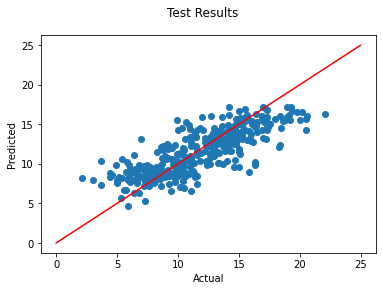

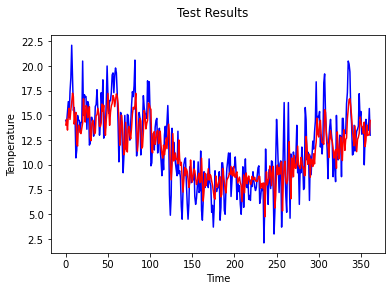

In [ ]:
# show scatterplots of actual vs. predicted for train and test
# make a prediction
pred = model.predict(X_test)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, pred))

actual = y_test # the actual
plt.scatter(x=actual, y=pred)
x = np.linspace(0,25) # 45 degree line from 0 to 25 (axes are the same)
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

# LSTM one layer model
Literally, just grab the code above and change SimpleRNN to LSTM and boom! you have a more sophisticated model.

In [ ]:
# now let's build a model

# since this is a univariate problem, n_features will be 1 (we also defined this before)
n_features = 1

# define model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, input_shape=(n_steps,n_features))) # notice how input shape goes in first layer
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=64, kernel_size=2))
model.add(MaxPooling1D(2))
model.add(Bidirectional(LSTM(32, activation='relu')))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model.fit(X_train, y_train,
          epochs=500,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 28, 128)           512       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 14, 128)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 13, 64)            16448     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 6, 64)            0         
 1D)                                                             
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                      

12/12 [==============================] - 0s 5ms/step
MAE:  2.1090203488070665


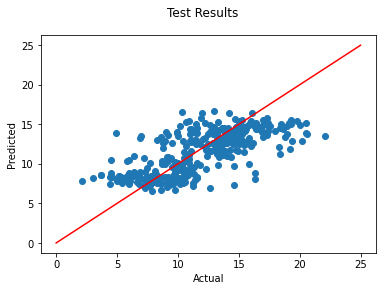

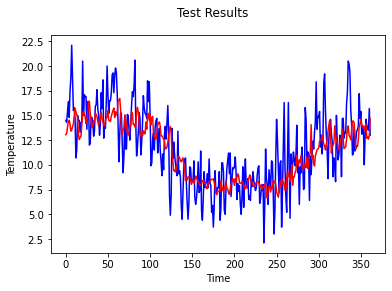

In [ ]:
# show scatterplots of actual vs. predicted for train and test
# make a prediction
pred = model.predict(X_test)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, pred))

actual = y_test # the actual
plt.scatter(x=actual, y=pred)
x = np.linspace(0,25) # 45 degree line from 0 to 25 (axes are the same)
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

# LSTM two layer model

In [ ]:
# now let's build a model

# since this is a univariate problem, n_features will be 1 (we also defined this before)
n_features = 1

# define model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, input_shape=(n_steps,n_features))) # notice how input shape goes in first layer
model.add(MaxPooling1D())
model.add(Conv1D(filters=32, kernel_size=3)) # notice how input shape goes in first layer
model.add(MaxPooling1D())
model.add(LSTM(30,
               return_sequences=True, # remember, if stacking layers, you need to return sequences!
               input_shape=(n_steps,n_features),
               activation='relu'))
model.add(Dropout(0.1))
model.add(LSTM(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)
# fit model (uses early stopping)
model.fit(X_train, y_train,
          epochs=500,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Epoch 1/500
522/522 [==============================] - 8s 10ms/step - loss: 17.0470 - mae: 3.1534 - val_loss: 8.7673 - val_mae: 2.3232
Epoch 2/500
522/522 [==============================] - 6s 11ms/step - loss: 12.9936 - mae: 2.8143 - val_loss: 7.6704 - val_mae: 2.1780
Epoch 3/500
522/522 [==============================] - 5s 10ms/step - loss: 11.0364 - mae: 2.5919 - val_loss: 6.7007 - val_mae: 2.0113
Epoch 4/500
522/522 [==============================] - 5s 9ms/step - loss: 10.3738 - mae: 2.5188 - val_loss: 9.2534 - val_mae: 2.4270
Epoch 5/500
522/522 [==============================] - 5s 10ms/step - loss: 10.1708 - mae: 2.5317 - val_loss: 8.9997 - val_mae: 2.4014
Epoch 6/500
522/522 [==============================] - 5s 10ms/step - loss: 10.1683 - mae: 2.4813 - val_loss: 8.9272 - val_mae: 2.3707
Epoch 7/500
522/522 [==============================] - 5s 10ms/step - loss: 10.0195 - mae: 2.4776 - val_loss: 8.0320 - val_mae: 2.2461
Epoch 8/500
522/522 [==============================] - 5

12/12 [==============================] - 1s 4ms/step
MAE:  1.8431918739613906


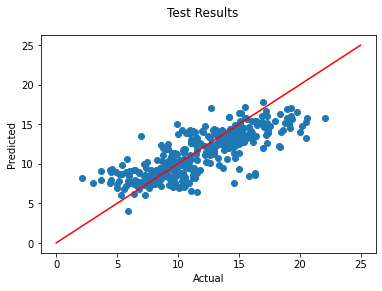

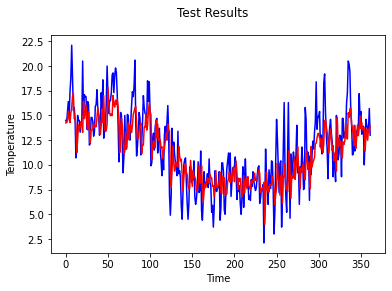

In [ ]:
# show scatterplots of actual vs. predicted for train and test
# make a prediction
pred = model.predict(X_test)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, pred))

actual = y_test # the actual
plt.scatter(x=actual, y=pred)
x = np.linspace(0,25) # 45 degree line from 0 to 25 (axes are the same)
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

# Baseline Model
What if you just use yesterday's value as the prediction?!

In [ ]:
# baseline model - prediction is just the previous time step (a tough one to beat!)
df['Baseline'] = df['Temp'].shift(1)
df.head()

,Date,Temp,Baseline
0,1981-01-01,20.7,NaN
1,1981-01-02,17.9,20.7
2,1981-01-03,18.8,17.9
3,1981-01-04,14.6,18.8
4,1981-01-05,15.8,14.6


In [ ]:
# if you wanted to see how this model does, use df['Baseline'] for the pred
# here's how I'd do it
y_test_baseline = df['Baseline'].tail(y_test.shape[0])
# check your work
y_test_baseline.shape

(362,)

In [ ]:
# check shapes, looks good!
y_test.shape

(362,)

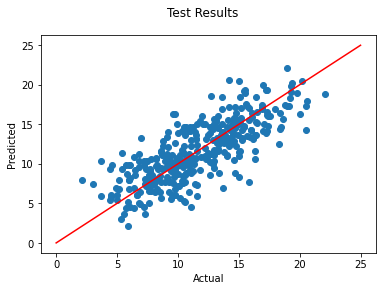

In [ ]:
# now set this equal to pred and repeat code!

# show scatterplots of actual vs. predicted for train and test
# make a prediction
pred = y_test_baseline # the pred
actual = y_test # the actual
plt.scatter(x=actual, y=pred)
x = np.linspace(0,25) # 45 degree line from 0 to 25 (axes are the same)
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

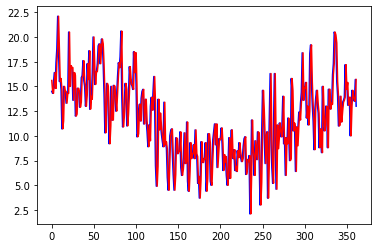

In [ ]:
# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.show()
# looks good, BUT it's not a smart model! all the data is just shifted.

In [ ]:
# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, pred)

2.025414364640884

In [ ]:
# our RNN models beats the baseline model!
# don't be FOOLED by the line plot... or model is 20% better than a dumb model!

# On Your Own
* Update the script to make some interesting comparisons of models - which one would you recommend to your boss?
* Can you analyze the distribution of errors instead of just MAE?
* Try even more architectures - play with number of filters, kernel size, number of layers, and see if you can beat 1.8 MAE.
* See if scalaing can help.